In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon) * 1
        p, r, f, s = precision_recall_fscore_support(gt, predictions,average='binary')

        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    
    return best_f1, best_epsilon

In [ ]:
tr_data = read_dataset('tr_server_data.csv')
cv_data = read_dataset('cv_server_data.csv')
gt_data = read_dataset('gt_server_data.csv')

n_training_samples = tr_data.shape[0]
n_dim = tr_data.shape[1]

print('Number of datapoints in training set: %d' % n_training_samples)
print('Number of dimensions/features: %d' % n_dim)


print(tr_data[1:5,:])

plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'o')
plt.show()

In [ ]:
mu, sigma = estimateGaussian(tr_data)
p = multivariateGaussian(tr_data,mu,sigma)

In [ ]:
#selecting optimal value of epsilon using cross validation
p_cv = multivariateGaussian(cv_data,mu,sigma)
fscore, ep = selectThresholdByCV(p_cv,gt_data)
print fscore, ep

In [ ]:
#selecting outlier datapoints 
outliers = np.asarray(np.where(p < ep))

In [ ]:
plt.figure()
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'bx')
plt.plot(tr_data[outliers,0],tr_data[outliers,1],'ro')
plt.show()

In [79]:
import pandas as pd

In [104]:
d = pd.read_csv('mavg.tsv','\t',header=None)
mavg = d.rolling(3).mean().dropna()
mavg_array = np.asarray(mavg)

In [105]:
print mavg_array

[[ 2004.             5.        ]
 [ 2005.             6.33333333]
 [ 2006.             7.33333333]
 [ 2007.             7.33333333]
 [ 2008.             6.        ]
 [ 2009.             4.        ]
 [ 2010.             4.66666667]
 [ 2011.             6.        ]]


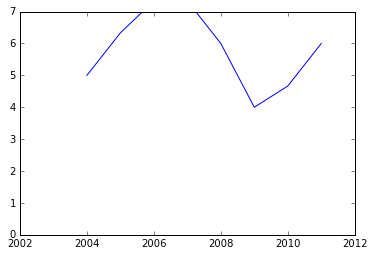

In [107]:
plt.figure()
plt.xlim([2002,2012])
plt.ylim([0,7])
plt.plot(mavg_array[:,0],mavg_array[:,1])